30415 손정훈, 30422 이호준
[자료 출처 - 기상자료개방포털](https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36)
주제 : 기상 정보를 통한 기온 예측


In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras.models import Sequential
pd.set_option('display.max_row', 100)

In [ ]:
#데이터가 1년마다 파일이 있기 때문에 다합쳐서 하나의 데이터프레임으로 만들어주기위한 작업
weather_df = DataFrame()
for i in range(91,100):
  num = ("%02d" % i)
  temp_df = pd.read_csv('csv/'+num+'.csv', encoding='cp949')
  weather_df = weather_df.append(temp_df)
for i in range(0,20): # 데이터는 19년도까지 학습에 사용하고 20년도 데이터를 가지고 실제로 적용해보기로 함
  num = ("%02d" % i)
  temp_df = pd.read_csv('csv/'+num+'.csv', encoding='cp949')
  weather_df = weather_df.append(temp_df)
#데이터프레임을 전처리하기전에 원본 데이터를 따로 저장
raw_weather_df = weather_df

In [ ]:
#기온과 관련된 모든 열과 대부분의 행에서 값이 NaN인 열 제거. 
#날짜도 제거해서 날짜와 관계없이 예측하도록 함
weather_df = weather_df.drop(['평균기온(°C)','최저기온(°C)','최고기온(°C)', '최저기온 시각(hhmi)','최고기온 시각(hhmi)','일시','지점','9-9강수(mm)', '합계 3시간 신적설(cm)', '일 최심적설 시각(hhmi)', '일 최심적설(cm)','안개 계속시간(hr)', '10분 최다강수량 시각(hhmi)', '10분 최다 강수량(mm)', '1시간 최다강수량(mm)', '1시간 최다 강수량 시각(hhmi)', '합계 일조 시간(hr)', '합계 일사(MJ/m2)','일 최심신적설(cm)','일 최심신적설 시각(hhmi)','합계 일조시간(hr)', '합계 일사량(MJ/m2)'], axis=1)
print(weather_df.isna().sum())

강수 계속시간(hr)          6550
일강수량(mm)             6548
최대 순간 풍속(m/s)           2
최대 순간 풍속 풍향(16방위)       2
최대 순간풍속 시각(hhmi)        2
최대 풍속(m/s)              2
최대 풍속 풍향(16방위)          2
최대 풍속 시각(hhmi)          2
평균 풍속(m/s)              3
풍정합(100m)               3
평균 이슬점온도(°C)            0
최소 상대습도(%)              1
최소 상대습도 시각(hhmi)        1
평균 상대습도(%)              0
평균 증기압(hPa)             0
평균 현지기압(hPa)            1
최고 해면기압(hPa)            0
최고 해면기압 시각(hhmi)        0
최저 해면기압(hPa)            2
최저 해면기압 시각(hhmi)        1
평균 해면기압(hPa)            1
가조시간(hr)                0
1시간 최다일사 시각(hhmi)      24
1시간 최다일사량(MJ/m2)       23
평균 전운량(1/10)            0
평균 중하층운량(1/10)          0
평균 지면온도(°C)             2
최저 초상온도(°C)             3
평균 5cm 지중온도(°C)      1471
평균 10cm 지중온도(°C)     1466
평균 20cm 지중온도(°C)     1468
평균 30cm 지중온도(°C)     1478
0.5m 지중온도(°C)        1472
1.0m 지중온도(°C)        1471
1.5m 지중온도(°C)        1472
3.0m 지중온도(°C)        1476
5.0m 지중온도(°C)        1467
합계 대형증발량(mm)         4705
합계 소형증발량(mm)

In [ ]:
#강수 계속시간과 일강수량은 비가 오지 않은 날에는 NaN으로 나옴. 이 두개의 열은 0으로 채우고 나머지 열들은 평균값으로 채움
def preprocess(data):
  rain_remain_time = data['강수 계속시간(hr)']
  daily_rain_amount = data['일강수량(mm)']
  data = data.drop(['강수 계속시간(hr)','일강수량(mm)' ], axis=1).fillna(weather_df.mean())
  data['강수 계속시간(hr)'] = rain_remain_time.fillna(rain_remain_time.mean())
  data['일강수량(mm)'] = daily_rain_amount.fillna(daily_rain_amount.mean())
  print('isna : ', data.isna().sum().sum())
  return data
#데이터 정규화 코드
def normalize(data):
  de_max = data.max(axis=0)
  de_min = data.min(axis=0)
  return (data - data.min(axis=0)) / (data.max(axis=0)-data.min(axis=0))
#온도 정규화 코드. 출력이 정규화 된 상태로 나오기 때문에 다시 xx도로 만들기 위해서 max와 min을 저장해서 denormalize_temperature 함수에서 사용
def normalize_temperature(data):
  global max
  global min
  max = data.max(axis=0)
  min = data.min(axis=0)
  return (data - data.min(axis=0)) / (data.max(axis=0)-data.min(axis=0))
#온도 역 정규화 코드
def denormalize_temperature(data):
  return (data * (max - min)) + min

In [ ]:
weather_df = preprocess(weather_df)
weather_df = normalize(weather_df)

isna :  0


In [ ]:
#학습용 데이터들을 분리시킴
train_data_rate = 0.7
boundary = round(weather_df.shape[0] * train_data_rate)
x_train = weather_df[:boundary]
x_test = weather_df[boundary:]

#weather_df에는 기온이 없기 때문에 기온은 원본 데이터프레임의 기온을 가져와서 분리함
y_train = normalize_temperature(raw_weather_df['평균기온(°C)'][:boundary])
y_test = normalize_temperature(raw_weather_df['평균기온(°C)'][boundary:])


x_train.shape, x_test.shape

((7414, 39), (3178, 39))

In [ ]:
#모델 제작. softsign 액티베이션 함수는 x / (|x| + 1) 모양의 softsign 함수
#코드 작성 초반에 정규화대신 표준화를 사용해서 음수가 나오다보니 음수값을 입력받으면 0을 반환하는 relu는 사용하기 힘들어서 음수 값을 출력할 수 있는 softsign을 선택
model = Sequential()
model.add(Dense(64, activation='softsign', input_shape=(39,)))
model.add(Dense(64, activation='softsign'))#활성화 함수 linear도 시도
model.add(Dense(1, activation='softsign'))
model.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2560      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#언제부터 loss값이 줄어들지 않는지 확인해서 에포크를 줄이는것보다 EarlyStopping을 사용해서 loss값이 줄어들지 않으면 알아서 멈추게 설정.
from keras.callbacks import EarlyStopping
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=500, callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    )
#알아서 멈출거니 에포크를 높게 설정

Epoch 1/500
742/742 [==============================] - 1s 748us/step - loss: 0.0058 - mae: 0.0527 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 2/500
742/742 [==============================] - 0s 582us/step - loss: 0.0017 - mae: 0.0313 - val_loss: 0.0011 - val_mae: 0.0248
Epoch 3/500
742/742 [==============================] - 0s 561us/step - loss: 0.0012 - mae: 0.0265 - val_loss: 0.0012 - val_mae: 0.0276
Epoch 4/500
742/742 [==============================] - 0s 560us/step - loss: 9.9463e-04 - mae: 0.0239 - val_loss: 0.0016 - val_mae: 0.0325
Epoch 5/500
742/742 [==============================] - 0s 561us/step - loss: 8.5703e-04 - mae: 0.0220 - val_loss: 9.0030e-04 - val_mae: 0.0235
Epoch 6/500
742/742 [==============================] - 0s 578us/step - loss: 7.6970e-04 - mae: 0.0205 - val_loss: 7.6891e-04 - val_mae: 0.0225
Epoch 7/500
742/742 [==============================] - 0s 561us/step - loss: 6.9307e-04 - mae: 0.0195 - val_loss: 8.3681e-04 - val_mae: 0.0233
Epoch 8/500
742/742 [======

In [ ]:
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)
print(test_mae_score)
#어디서 본듯한 코드. 오차 출력

100/100 [==============================] - 0s 364us/step - loss: 6.3740e-04 - mae: 0.0223
0.02228303626179695


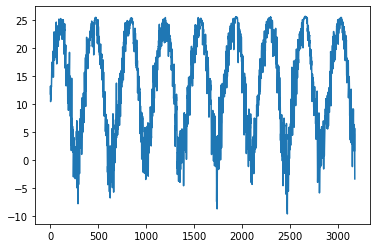

In [ ]:
pred = model.predict(x_test)
#x_test를 예측한 값이 정규화된 값이기때문에 역정규화해줌
predict_denormalize = denormalize_temperature(pred)
plt.plot(predict_denormalize)

In [ ]:
#훈련된 데이터를 가지고 2020년 기온 예측을 해보자!
#위에서 했던 것처럼 몇가지 열 삭제하고 전처리 해줌
weather_2020_df = pd.read_csv('csv/20.csv', encoding='cp949')
temperature_2020_df = weather_2020_df['평균기온(°C)']
weather_2020_df = weather_2020_df.drop(['합계 일조시간(hr)','평균기온(°C)','최저기온(°C)','최고기온(°C)', '최저기온 시각(hhmi)','최고기온 시각(hhmi)','일시','지점','9-9강수(mm)', '합계 3시간 신적설(cm)', '일 최심적설 시각(hhmi)', '일 최심적설(cm)','안개 계속시간(hr)', '10분 최다강수량 시각(hhmi)', '10분 최다 강수량(mm)', '1시간 최다강수량(mm)', '1시간 최다 강수량 시각(hhmi)','일 최심신적설(cm)','일 최심신적설 시각(hhmi)', '합계 일사량(MJ/m2)'], axis=1)
weather_2020_df = preprocess(weather_2020_df)
weather_2020_df = normalize(weather_2020_df)
normalize_temperature(temperature_2020_df)

isna :  0


0      0.211679
1      0.289538
2      0.262774
3      0.294404
4      0.296837
         ...   
361    0.406326
362    0.428224
363    0.267640
364    0.000000
365    0.048662
Name: 평균기온(°C), Length: 366, dtype: float64

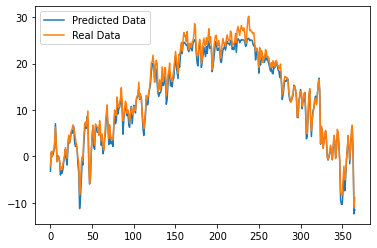

In [ ]:
#위의 x_test를 예측하던 모델과 같은 모델에 2020년 데이터를 넣고 역정규화를 함. 파란 선이 예측 데이터, 주황색 선이 진짜 데이터. 
pred = model.predict(weather_2020_df)
pred = denormalize_temperature(pred)
plt.plot(pred, label='Predicted Data')
plt.plot(temperature_2020_df, label = 'Real Data')
plt.legend(loc='upper left')
plt.show()